## Import Required library

In [2]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

## Read clean data

In [10]:
#Read cleaned emission and carbon captured data
emission_cc_data = pd.read_csv('data\cleaned_data.csv')

In [11]:
#print data set info
emission_cc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   country          107 non-null    object 
 1   year             107 non-null    int64  
 2   total_ghg        107 non-null    float64
 3   max_capacity_mt  107 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 3.5+ KB


In [12]:
#look for missing values
emission_cc_data.isna().sum()

country            0
year               0
total_ghg          0
max_capacity_mt    0
dtype: int64

In [13]:
#data stastics
emission_cc_data.describe()

,year,total_ghg,max_capacity_mt
count,107.000000,107.000000,107.000000
mean,2018.504673,681.724393,8.330838
std,4.107916,1519.713665,16.054493
min,2007.000000,0.000000,0.000000
25%,2018.000000,0.000000,0.750000
50%,2020.000000,39.180000,2.650000
75%,2021.500000,505.135000,8.300000
max,2022.000000,5634.800000,96.735000


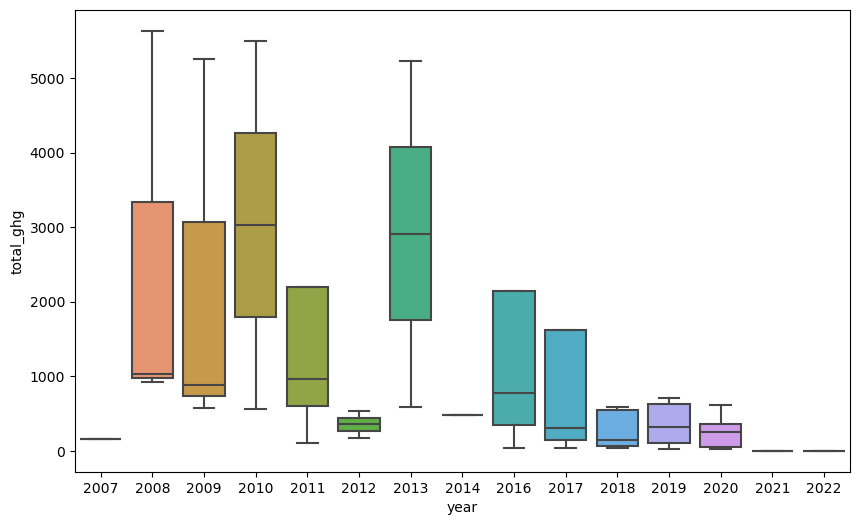

In [16]:
#look for outliers using boxplot for both carbon capture
warnings.filterwarnings("ignore")
plt.figure(figsize=(10, 6))
sns.boxplot(x='year', y='total_ghg', data=emission_cc_data, showfliers=False)
plt.show()